In [14]:
import numpy as np
import matplotlib.pyplot as plt
from lace.cosmo import camb_cosmo
from forestflow.model_p3d_arinyo import ArinyoModel
from picca import constants
import camb

In [15]:
# MW21 cosmology values
hubble, z = 0.71, 2.5
omegab, omegam = 0.046, 0.27
omegal = 1 - omegam
ns = 0.96

# Linear matter power spectrum

In [16]:
from camb import model
pars = camb.set_params(H0=100*hubble, ombh2=omegab*(hubble**2), omch2=omegam*(hubble**2), ns=ns)
pars.set_matter_power(redshifts=[z], kmax=100)
pars.NonLinear = model.NonLinear_none  # Linear spectra
results = camb.get_results(pars)
k_lin, z, pk = results.get_linear_matter_power_spectrum(hubble_units=False, k_hunit=False, ) 

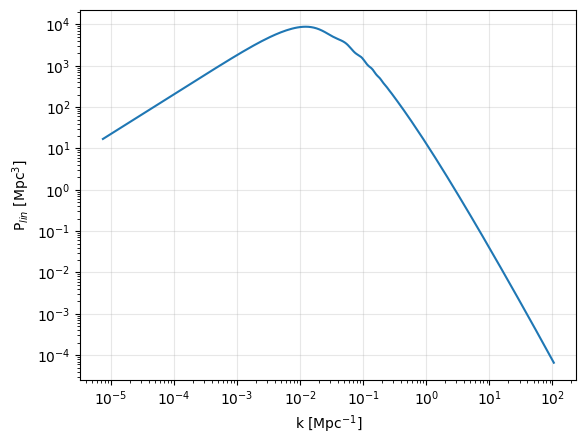

In [17]:
plt.plot(k_lin, pk[0, :])
plt.xscale('log')
plt.yscale('log')
plt.grid(alpha=0.3)
plt.xlabel(r'k [Mpc$^{-1}$]')
plt.ylabel(r'P$_{lin}$ [Mpc$^{3}$]');

# HCDs

## W1 and W2 (with MW21 column density distribution)

Their description of f_Nhi is a broken potential function, with one segment for 19 < logNhi < 20.3 cm^-2 and the other 20.3 < logNhi < 22 cm^-2 

In [19]:
def f_Nhi(colden, k, b):
    y = k*(colden**b)
    return y

The parameters b1 and b2 are given in the paper. k1 and k2 are determinated so that:
- the integration of f_nhi from logNhi=19 to logNhi=20.3 (cm^-2) is 0.1
- f_Nhi(k1, b1) = f_Nhi(k2, b2) at logNhi = 20.3

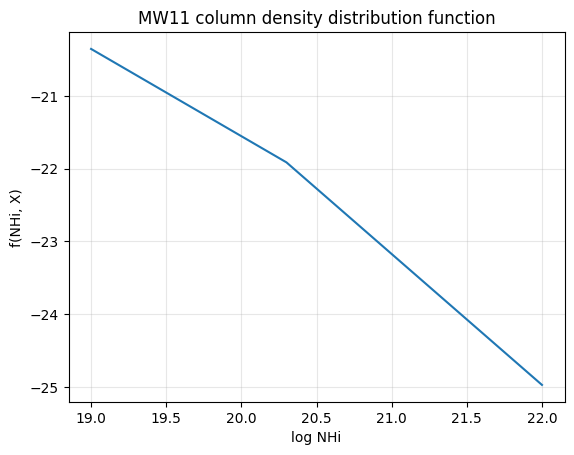

In [23]:
k1, b1 = 280.14, -1.2
k2, b2 = 4.24e14, -1.8

colden1, colden2 = 10**(np.linspace(19, 20.3, 100)), 10**(np.linspace(20.3, 22, 100))
cddf1, cddf2 = f_Nhi(colden1, k1, b1), f_Nhi(colden2, k2, b2)

NHirange_mw11 = np.concatenate([colden1, colden2])
fnhi_mw11 = np.concatenate([cddf1, cddf2])

plt.plot(np.log10(NHirange_mw11), np.log10(fnhi_mw11))
plt.xlabel('log NHi')
plt.ylabel('f(NHi, X)')
plt.title('MW11 column density distribution function')
plt.grid(alpha=0.3);

With this f_Nhi we can define the column density distribution function as:

In [26]:
H_z = 100*hubble*np.sqrt(omegal + omegab*((1+z)**3))  # kms^-1 Mpc^-1
c_kms = constants.speed_light*1e-3  # kms^-1
factor = np.sqrt((1+z)/omegam)
cddf_mw11 = fnhi_mw11*factor*H_z/c_kms

And compute W1 and W2

In [ ]:
from w1_w2 import wave_to_fft_profile, resample_to_logk

In [34]:
wave_log = np.linspace(np.log10(2800), np.log10(6800), 2**12) # Angstrom
wave = 10**wave_log

w1_int = []
w2_int = []
for i, nhi_value in enumerate(NHirange_mw11):
    k_w1w2, d, Deltax = wave_to_fft_profile(wave, z, np.log10(nhi_value), omegam=omegam, omegal=omegal, hubble=hubble)
    w1_int.append(cddf_mw11[i]*(d**2))
    w2_int.append(cddf_mw11[i]*d)

w1_int = np.array(w1_int)
w2_int = np.array(w2_int)

w1 = np.trapezoid(w1_int, NHirange_mw11, axis=0)
w2 = np.trapezoid(w2_int, NHirange_mw11, axis=0)

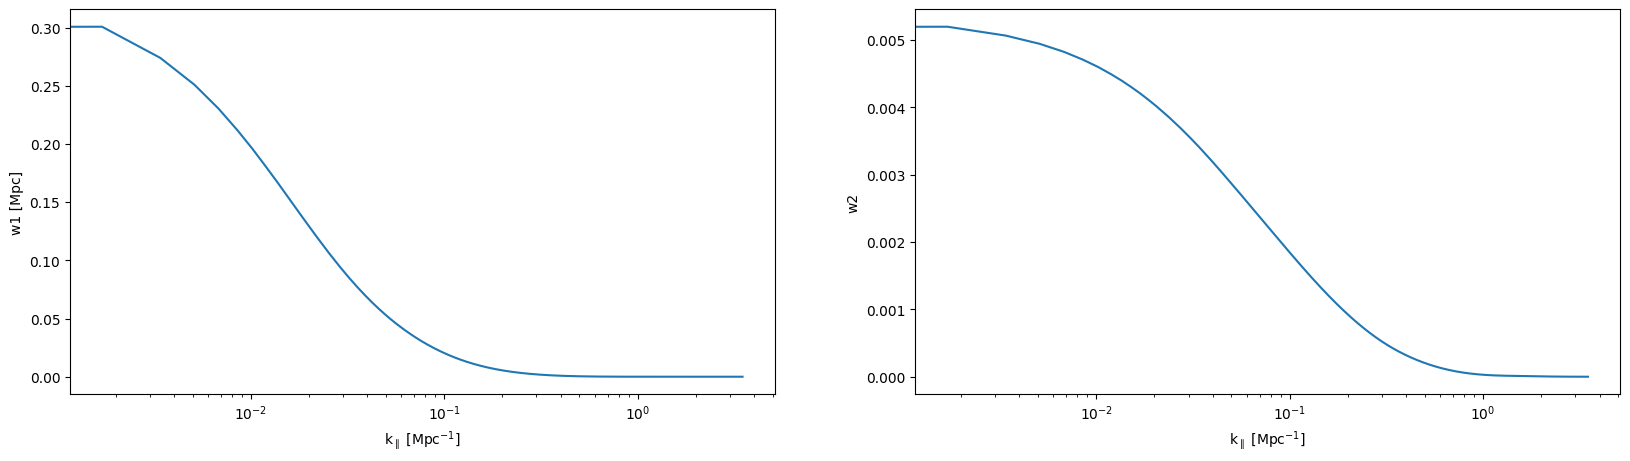

In [35]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.plot(k_w1w2, w1, label='w1')
plt.ylabel(r'w1 [Mpc]')
plt.xscale('log')
plt.xlabel(r'k$_\parallel$ [Mpc$^{-1}$]');

plt.subplot(1, 2, 2)
plt.plot(k_w1w2, w2, label='w2')
plt.ylabel(r'w2')
plt.xscale('log')
plt.xlabel(r'k$_\parallel$ [Mpc$^{-1}$]');

We can resample to logarithmic binning of k_paralel taking into account Nyquist frequency

In [36]:
print(r'Min value of k_los is', k_w1w2.min(), 'h/Mpc')
print(r'Max value of k_los is', k_w1w2.max(), 'h/Mpc')
print(r'But Nyquist frecuency is', np.pi/(Deltax), 'h/Mpc')
k_los, w1 = resample_to_logk(k_w1w2, w1, k_max=np.pi/(Deltax*2))  # Resample to logarithmic binning
k_los, w2 = resample_to_logk(k_w1w2, w2, k_max=np.pi/(Deltax*2))  # Resample to logarithmic binning
print('After truncation to avoid Nyquist frecuency')
print(r'Min value of k_los is', k_los.min(), 'Mpc^-1')
print(r'Max value of k_los is', k_los.max(), 'Mpc^-1')

Min value of k_los is 0.0 h/Mpc
Max value of k_los is 3.487529232174188 h/Mpc
But Nyquist frecuency is 3.487529232174188 h/Mpc
After truncation to avoid Nyquist frecuency
Min value of k_los is 0.0017028951328975535 Mpc^-1
Max value of k_los is 1.743764616087094 Mpc^-1


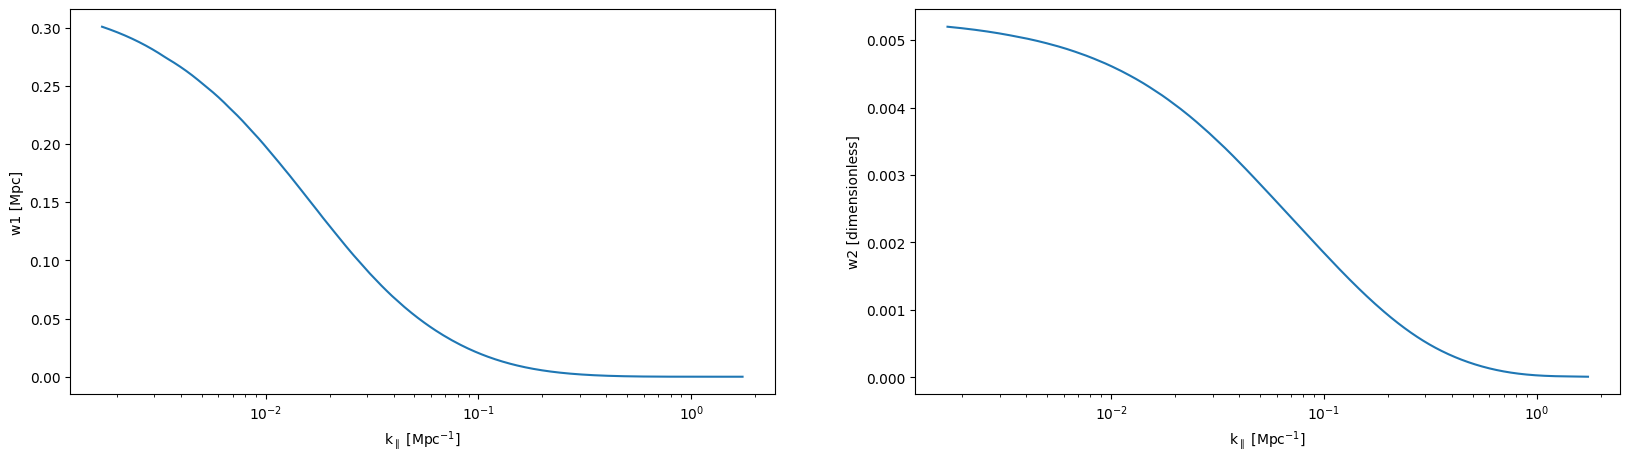

In [37]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.plot(k_los, w1, label='w1')
plt.ylabel(r'w1 [Mpc]')
plt.xscale('log')
plt.xlabel(r'k$_\parallel$ [Mpc$^{-1}$]');

plt.subplot(1, 2, 2)
plt.plot(k_los, w2, label='w2')
plt.ylabel(r'w2 [dimensionless]')
plt.xscale('log')
plt.xlabel(r'k$_\parallel$ [Mpc$^{-1}$]');

## P3D

In [39]:
bias_hcd = 2
mu = np.linspace(0, 1, 11)

Using mu and k_los from W1 and W2 we can define k

In [40]:
# k_max = k_los.max()/mu.min() This would be infinite
k_max = 40  # Mpc^-1
k_min = k_los.min()/mu.max()
print('k values can range from', k_min, 'to', k_max, 'Mpc^-1')
k = np.logspace(np.log10(k_min), np.log10(k_max), len(k_los))  # New k array

k values can range from 0.0017028951328975535 to 40 Mpc^-1


We should resample linear matter power spectrum into the new k array

In [41]:
plin = np.interp(k, k_lin, pk[0, :], right=np.nan, left=np.nan)  # Plin values in that new k array
del k_lin, pk

And calculate P3D:

In [47]:
P3d_hcd = []
for mu_value in mu:
    if mu_value == 0:  # k_los = 0. We assume that w2[klos=0]= w2[klos.min]
        w2_k_mu = w2[0]
    else:
        k_los_mu = k * mu_value  # Given mu, the k_los values associated to k
        w2_k_mu = np.interp(k_los_mu, k_los, w2, left=np.nan, right=np.nan)  # We evaluate the function w2 in those k_los_mu values
    Pf_mu = (w2_k_mu**2)*((bias_hcd + mu_value**2)**2)*plin
    P3d_hcd.append(Pf_mu)

P3d_hcd = np.array(P3d_hcd)

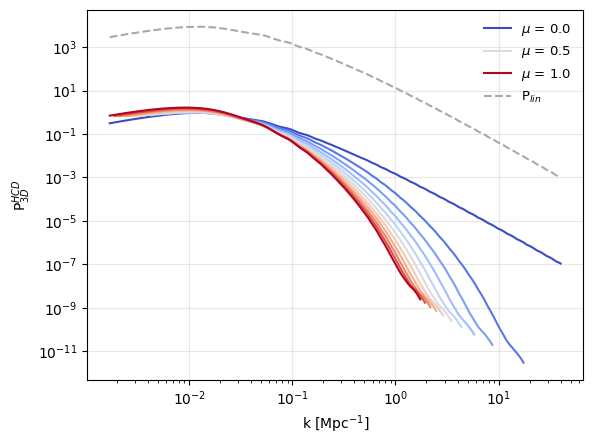

In [48]:
colors = plt.cm.coolwarm(np.linspace(0,1,len(mu)))     
plt.gca().set_prop_cycle('color', colors)

for i in np.arange(len(mu)):
    if i in [0, 5, 10]:
        plt.plot(k, P3d_hcd[i, :], label = '$\mu$ = %.1f' %mu[i])
    else:
        plt.plot(k, P3d_hcd[i, :])
plt.plot(k, plin, color='darkgrey', linestyle='--', label=r'P$_{lin}$')
plt.xscale('log')
plt.yscale('log')
plt.grid(alpha=0.3)
plt.legend(fontsize=9.5, frameon=False)
plt.xlabel(r'k [Mpc$^{-1}$]')
plt.ylabel(r'P$_{3D}^{HCD}$');


## P1d

In [49]:
integral = []
for k_los_value in k_los:
    mu_value_i = k_los_value/k # Given k_los value, what mu array is associated 
    mask = (mu_value_i > 0.0) & (mu_value_i <= 1)
    mu_value, k_value = mu_value_i[mask], k[mask]
    kperp_value = np.sqrt(k_value**2 - k_los_value**2)  
    plin_value = np.interp(k_value, k, plin, right=np.nan, left=np.nan)
    y = plin_value*((bias_hcd + mu_value**2)**2)*kperp_value/(2*np.pi)
    integral.append(np.trapezoid(y, kperp_value))

P1d_hcd = w1 + (w2**2)*np.array(integral)

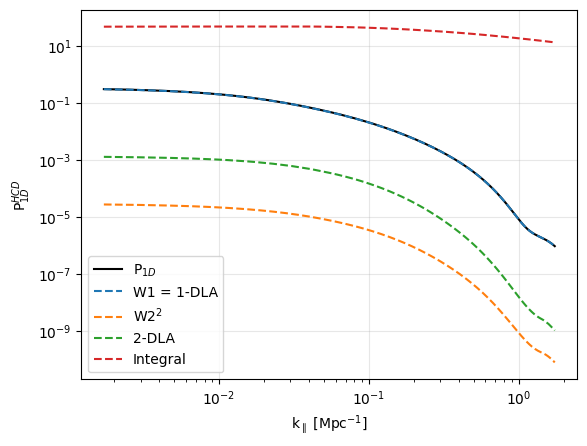

In [50]:
plt.figure()
plt.plot(k_los, P1d_hcd, color='k', label=r'P$_{1D}$')
plt.plot(k_los, w1, linestyle='--', label='W1 = 1-DLA')
plt.plot(k_los, w2**2, linestyle='--', label=r'W2$^2$')
plt.plot(k_los, (w2**2)*np.array(integral), linestyle='--', label='2-DLA')
plt.plot(k_los, np.array(integral), linestyle='--', label='Integral')
plt.xscale('log')
plt.yscale('log')
plt.grid(alpha=0.3)
plt.xlabel(r'k$_\parallel$ [Mpc$^{-1}$]')
plt.ylabel(r'P$_{1D}^{HCD}$')
plt.legend();


# Lya

## P3D

In [51]:
from lace.cosmo.camb_cosmo import dkms_dMpc as dkms_dMpc_func
cosmocamb = camb_cosmo.get_cosmology(H0=100*hubble, omch2=omegam*(hubble**2), ombh2=omegab*(hubble**2), ns=ns)
dkms_dMpc = dkms_dMpc_func(cosmo=cosmocamb, z=2.5) # This is to change from Mpc to km/s

Caution: we are using inverse km/s and inverse Mpc as k units, so

- To change from k[s/km] to k[Mpc^-1], we need to multiply by dkms_dMpc
- To change from k[Mpc^-1] to k[s/km], we need to divide by dKms_dMpc

In [52]:
bias_lya = -0.18
k_d = 0.08*dkms_dMpc  # Mpc^-1

In [56]:
P3d_lya = []
for mu_value in mu:
    k_los_value = k*mu_value
    exp = np.exp(-(k_los_value**2/k_d**2))
    pf_lya = (bias_lya**2)*((1+mu_value**2)**2)*exp*plin
    P3d_lya.append(pf_lya)

P3d_lya = np.array(P3d_lya)

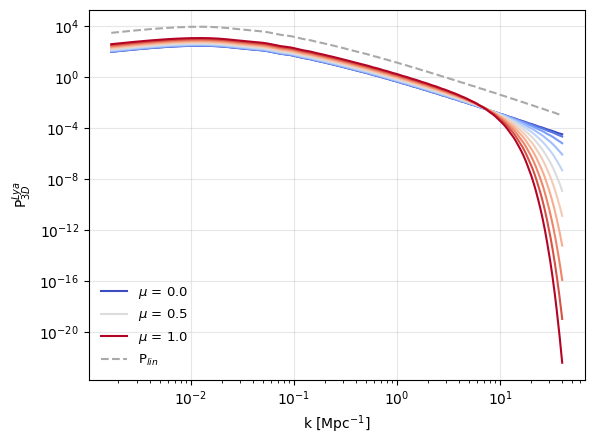

In [57]:
colors = plt.cm.coolwarm(np.linspace(0,1,len(mu)))     
plt.gca().set_prop_cycle('color', colors)

for i in np.arange(len(mu)):
    if i in [0, 5, 10]:
        plt.plot(k, P3d_lya[i, :], label = '$\mu$ = %.1f' %mu[i])
    else:
        plt.plot(k, P3d_lya[i, :])
plt.plot(k, plin, color='darkgrey', linestyle='--', label=r'P$_{lin}$')
plt.xscale('log')
plt.yscale('log')
plt.grid(alpha=0.3)
plt.legend(fontsize=9.5, frameon=False)
plt.xlabel(r'k [Mpc$^{-1}$]')
plt.ylabel(r'P$_{3D}^{Lya}$');

## P1D

We need to change from P3d(mu, k) into P3d(k_los, kperp)

In [58]:
kperp_max = np.sqrt(k.max()**2-k_los.max()**2)
kperp = np.logspace(np.log10(k_los.min()/10), np.log10(kperp_max), len(k))

KPAR, KPERP = np.meshgrid(k_los, kperp, indexing='ij')
K_TOTAL = np.sqrt(KPAR**2 + KPERP**2)
MU_EFF = KPAR/K_TOTAL

from scipy.interpolate import RegularGridInterpolator

interp = RegularGridInterpolator(
    (mu, k), 
    P3d_lya, 
    bounds_error=False, 
    fill_value=None  
)

points_target = np.stack([MU_EFF.ravel(), K_TOTAL.ravel()], axis=-1)
P1d_lya_newgrid = interp(points_target).reshape(K_TOTAL.shape)

And now we can integrate

In [59]:
P1d_lya = np.trapezoid(P1d_lya_newgrid*kperp/(2*np.pi), kperp)

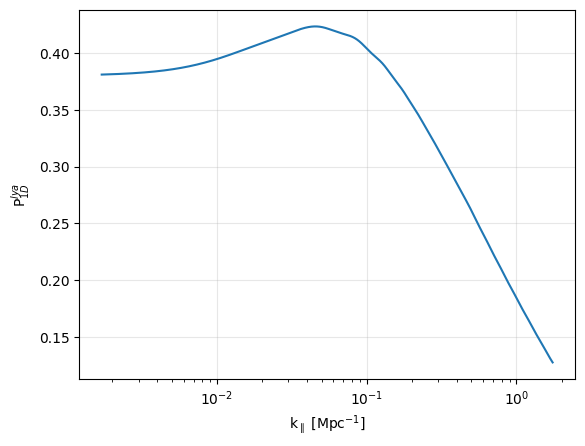

In [61]:
plt.plot(k_los, P1d_lya)
plt.xscale('log')
plt.grid(alpha=0.3)
plt.xlabel(r'k$_\parallel$ [Mpc$^{-1}$]')
plt.ylabel(r'P$_{1D}^{lya}$');

# Comparison with Mcquinn

In [62]:
ratio_p3d = P3d_hcd/P3d_lya

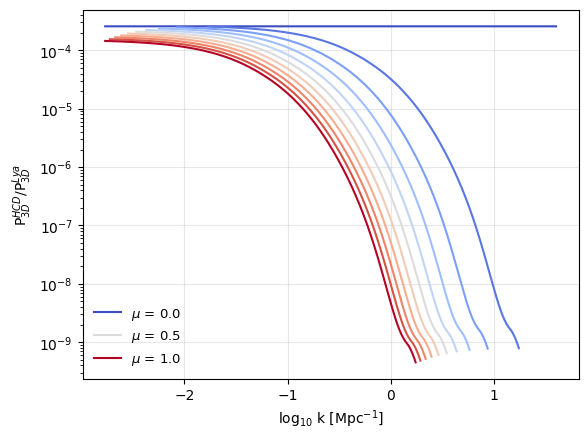

In [ ]:
colors = plt.cm.coolwarm(np.linspace(0,1,len(mu)))     
plt.gca().set_prop_cycle('color', colors)

for i in np.arange(len(mu)):
    if i in [0, 5, 10]:
        plt.plot(np.log10(k), ratio_p3d[i, :], label = '$\mu$ = %.1f' %mu[i])
    else:
        plt.plot(np.log10(k), ratio_p3d[i, :])
plt.yscale('log')
plt.grid(alpha=0.3)
plt.legend(fontsize=9.5, frameon=False)
plt.xlabel(r'log$_{10}$ k [Mpc$^{-1}$]')
plt.ylabel(r'P$_{3D}^{HCD}$/P$_{3D}^{Lya}$');

But in Fig.B1 they are using k_los instead of k, let's change it then:

In [65]:
ratio_p3d_klos, k_los_ratio = [], []
for i, mu_value in enumerate(mu):
    k_los_value = k * mu_value
    k_los_ratio.append(k_los_value)
    ratio_p3d_klos.append(ratio_p3d[i, :])

ratio_p3d_klos, k_los_ratio = np.array(ratio_p3d_klos), np.array(k_los_ratio)  

/var/folders/4r/vx1gr4gd4p99y59swb8x2lzr0000gn/T/ipykernel_83200/842885180.py:9: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(k_los_ratio[i, :]), ratio_p3d_klos[i, :], label = '$\mu$ = %.1f' %mu[i])
/var/folders/4r/vx1gr4gd4p99y59swb8x2lzr0000gn/T/ipykernel_83200/842885180.py:24: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(k_los_ratio[i, :]), ratio_p3d_klos[i, :], label = '$\mu$ = %.1f' %mu[i])


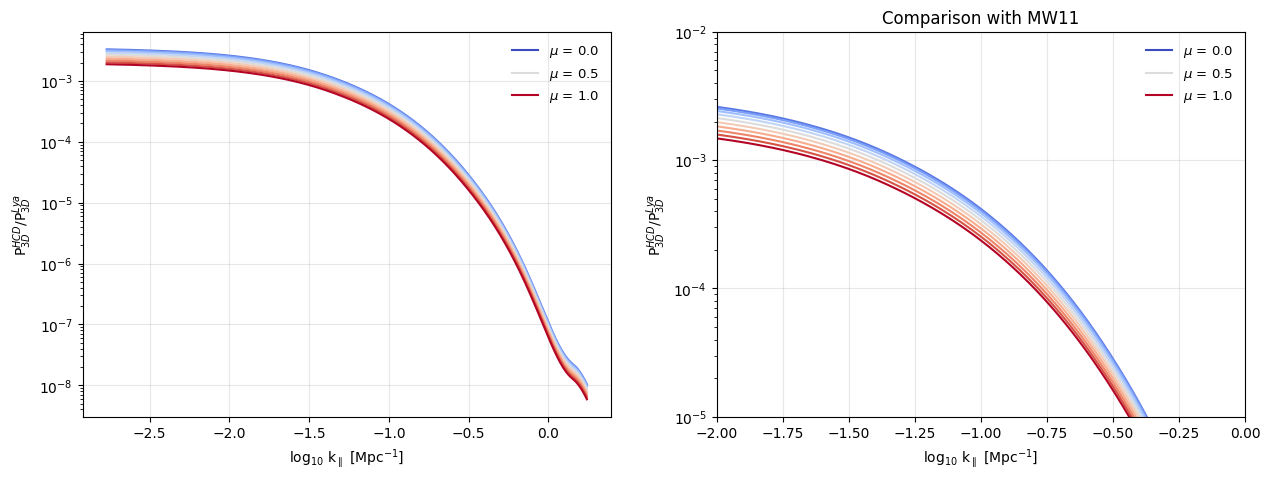

In [67]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
colors = plt.cm.coolwarm(np.linspace(0,1,len(mu)))     
plt.gca().set_prop_cycle('color', colors)

for i in np.arange(len(mu)):
    if i in [0, 5, 10]:
        plt.plot(np.log10(k_los_ratio[i, :]), ratio_p3d_klos[i, :], label = '$\mu$ = %.1f' %mu[i])
    else:
        plt.plot(np.log10(k_los_ratio[i, :]), ratio_p3d_klos[i, :])
plt.yscale('log')
plt.grid(alpha=0.3)
plt.legend(fontsize=9.5, frameon=False)
plt.xlabel(r'log$_{10}$ k$_\parallel$ [Mpc$^{-1}$]')
plt.ylabel(r'P$_{3D}^{HCD}$/P$_{3D}^{Lya}$');

plt.subplot(1, 2, 2)
colors = plt.cm.coolwarm(np.linspace(0,1,len(mu)))     
plt.gca().set_prop_cycle('color', colors)

for i in np.arange(len(mu)):
    if i in [0, 5, 10]:
        plt.plot(np.log10(k_los_ratio[i, :]), ratio_p3d_klos[i, :], label = '$\mu$ = %.1f' %mu[i])
    else:
        plt.plot(np.log10(k_los_ratio[i, :]), ratio_p3d_klos[i, :])
plt.yscale('log')
plt.grid(alpha=0.3)
plt.legend(fontsize=9.5, frameon=False)
plt.xlabel(r'log$_{10}$ k$_\parallel$ [Mpc$^{-1}$]')
plt.ylabel(r'P$_{3D}^{HCD}$/P$_{3D}^{Lya}$')
plt.xlim(-2, 0)
plt.ylim(1e-5, 1e-2)
plt.title('Comparison with MW11');

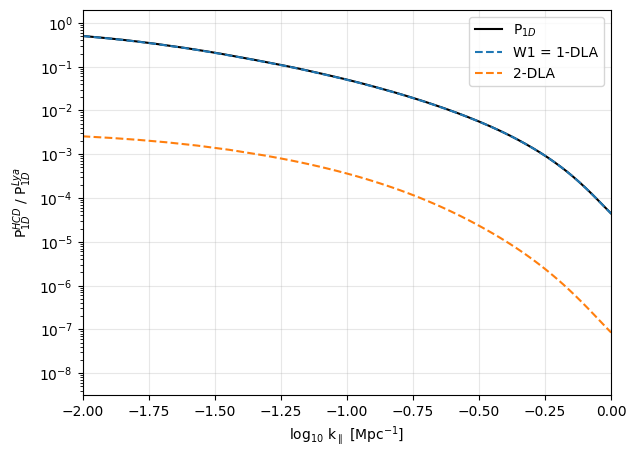

In [70]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(np.log10(k_los), P1d_hcd/P1d_lya, color='k', label=r'P$_{1D}$')
plt.plot(np.log10(k_los), w1/P1d_lya, linestyle='--', label='W1 = 1-DLA')
plt.plot(np.log10(k_los), (w2**2)*np.array(integral)/P1d_lya, linestyle='--', label='2-DLA')
plt.grid(alpha=0.3)
plt.yscale('log')
plt.xlabel(r'log$_{10}$ k$_\parallel$ [Mpc$^{-1}$]')
plt.ylabel(r'P$_{1D}^{HCD}$ / P$_{1D}^{Lya}$')
plt.legend()
plt.xlim(-2, 0);